In [3]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools
import matplotlib.pyplot as plt

<AxesSubplot:>

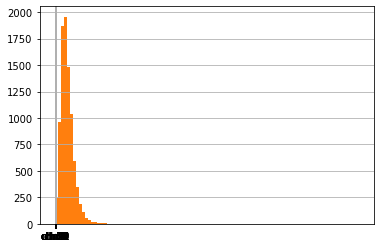

In [4]:
# Read and visualuse .bed file
pos_df = pd.read_csv('GSE107690_K562_High_confidence_peaks.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [5]:
# Filtration
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd \
 + pos_df_filter.right_add_len
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd \
 - pos_df_filter.new_chromStart
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,713977,714310,333,179,89,90,713888,714400,512
1,chr1,762850,762982,132,380,190,190,762660,763172,512
2,chr1,840076,840205,129,383,191,192,839885,840397,512
3,chr1,894635,894796,161,351,175,176,894460,894972,512
4,chr1,935414,935699,285,227,113,114,935301,935813,512


In [6]:
# Save data
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('G4_Chip_seq_filter_norm_to_500.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('G4_Chip_seq_filter_500.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('G4_Chip_seq_positions.csv')

In [7]:
# One Hot Encoding
import numpy as np
from sklearn.preprocessing import OneHotEncoder
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }
pos_df_filter = pd.read_csv('G4_Chip_seq_positions.csv', index_col=0)
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,713977,714310,333,179,89,90,713888,714400,512
1,chr1,762850,762982,132,380,190,190,762660,763172,512
2,chr1,840076,840205,129,383,191,192,839885,840397,512
3,chr1,894635,894796,161,351,175,176,894460,894972,512
4,chr1,935414,935699,285,227,113,114,935301,935813,512


In [8]:
# Normalisation
one_hot_quads = []
line_num = 0
with open('G4_Chip_seq_quadruplex_norm_to_500.fa', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s is not '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-8-56be079c6ab7>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if s is not '\n':


FileNotFoundError: ignored

In [ ]:
# Save
np.save('G4_Chip_seq_quadruplex_norm.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('G4_Chip_seq_quadruplex_norm_to_500.fa', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s is not '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('G4_Chip_seq_quadruplex_norm_quad_labeled.npy',
 one_hot_quads_np)